### Описание задания:
Обучить свёрточную сеть для классификации изображений на данных CIFAR10.

### Задачи:

1) Минимизировать многоклассовую кроссэнтропию с помощью sgd. Получить сеть, которая достигнет не менее 45% accuracy на тестовых данных. Поскольку в y_train лежат номера классов, Keras нужно либо указать sparse функции потерь и метрики оценки качества классификации (sparse_categorical_crossentropy и sparse_categorical_accuracy), либо конвертировать метки в one-hot формат.
2) Реализуйте небольшую свёрточную сеть:
- Входной слой
- Свёртка 3x3 с 10 фильтрами
- Нелинейность на ваш вкус
- Max-pooling 2x2
- Вытягиваем оставшееся в вектор (Flatten)
- Полносвязный слой на 100 нейронов
- Нелинейность на ваш вкус
- Выходной полносвязный слой с softmax
- Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше 50%.
3) Использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Определить какой из методов работает лучше.
4) Добавить нормализацию по батчу (BatchNormalization) между свёрткой и активацией. Попробовать использовать несколько нормализаций — в свёрточных и полносвязных слоях.
5) Посмотреть на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху). Найти такое значение, при котором модель быстрее достигает точности 55%.
6) Попробовать найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Пояснить, что вы понимаете под "наилучшей" кривой обучения.
7) Обучить большую свёрточную сеть, которая даст на тестовой выборке accuracy больше 80%. В этом задании требуется провести эксперименты, сравнив их между собой в конце. 

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import OrderedDict

from keras import backend
from keras import layers
from keras.datasets import cifar10
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Загрузка данных

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=21)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


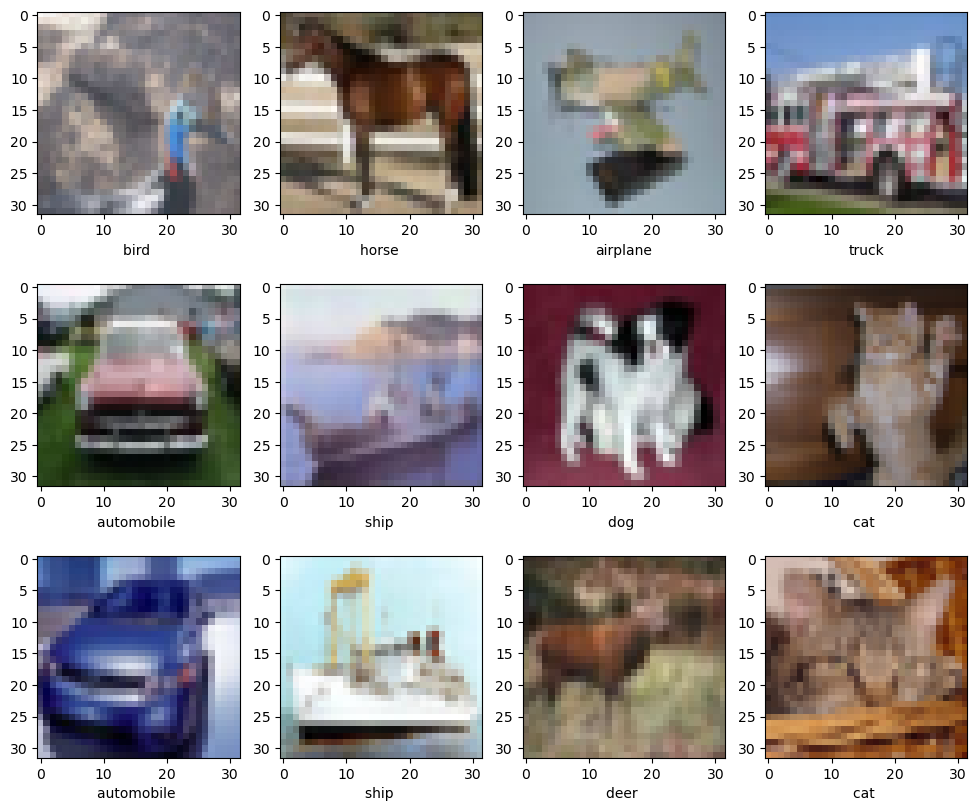

In [3]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

### Подготовка данных

Преобразуем каждый пиксель изображения из кодировки тройкой чисел (RGB) от 0 до 255 в диапазон данных [0, 1].

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

### 0. Создание простой нейросети:

- принимает на вход картинки размера 32 x 32 x 3;
- вытягивает их в вектор (keras.layers.Flatten);
- пропускает через 1 или 2 полносвязных слоя;
- выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [6]:
model = Sequential()
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [7]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 302ms/step
Успех!


### 1. Минимизация многоклассовой кроссэнтропии с помощью sgd. Получение сети, которая достигнет не менее 45% accuracy

In [8]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=None)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=None)

In [9]:
y_train.shape, y_val.shape

((40000, 10), (10000, 10))

#### Подключение callbacks

In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    keras.callbacks.LearningRateScheduler(scheduler),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [12]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 32)                98336     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train,
          y_train,
          batch_size=32,
          validation_split=0.2,
          verbose=2,
          epochs=20,
          callbacks = callbacks,
          validation_data=[X_val, y_val])

Epoch 1/20
1250/1250 - 10s - loss: 2.0043 - accuracy: 0.2639 - val_loss: 1.8657 - val_accuracy: 0.3376 - lr: 0.0100 - 10s/epoch - 8ms/step
Epoch 2/20
1250/1250 - 7s - loss: 1.8311 - accuracy: 0.3467 - val_loss: 1.7715 - val_accuracy: 0.3735 - lr: 0.0100 - 7s/epoch - 6ms/step
Epoch 3/20
1250/1250 - 6s - loss: 1.7645 - accuracy: 0.3705 - val_loss: 1.7503 - val_accuracy: 0.3778 - lr: 0.0100 - 6s/epoch - 5ms/step
Epoch 4/20
1250/1250 - 6s - loss: 1.7213 - accuracy: 0.3899 - val_loss: 1.7026 - val_accuracy: 0.3973 - lr: 0.0100 - 6s/epoch - 5ms/step
Epoch 5/20
1250/1250 - 8s - loss: 1.6875 - accuracy: 0.4006 - val_loss: 1.6854 - val_accuracy: 0.4003 - lr: 0.0100 - 8s/epoch - 6ms/step
Epoch 6/20
1250/1250 - 7s - loss: 1.6613 - accuracy: 0.4106 - val_loss: 1.6998 - val_accuracy: 0.4034 - lr: 0.0100 - 7s/epoch - 6ms/step
Epoch 7/20
1250/1250 - 6s - loss: 1.6365 - accuracy: 0.4202 - val_loss: 1.6251 - val_accuracy: 0.4278 - lr: 0.0100 - 6s/epoch - 5ms/step
Epoch 8/20
1250/1250 - 7s - loss: 1.615

In [15]:
from sklearn.metrics import accuracy_score
y_pred = [np.argmax(prob) for prob in model.predict(X_test)]
test_acc = accuracy_score(y_test, y_pred)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"

313/313 [==============================] - 2s 4ms/step

 Test_acc = 0.465


**Вывод:** простой моделью нейросети с использование метода оптимизации SGD была достигнута необходимая accuracy выше 45%

### 2. Реализация небольшой свёрточной сети

**Требования:** 
- Входной слой
- Свёртка 3x3 с 10 фильтрами
- Нелинейность по выбору
- Max-pooling 2x2
- Вытягиваем оставшееся в вектор (Flatten)
- Полносвязный слой на 100 нейронов
- Нелинейность по выбору
- Выходной полносвязный слой с softmax

In [16]:
conv_model = Sequential([
    layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [17]:
conv_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [18]:
conv_model.fit(X_train,
               y_train,
               batch_size=32,
               validation_split=0.2,
               verbose=2,
               epochs=20,
               callbacks = callbacks,
               validation_data=[X_val, y_val])

Epoch 1/20
1250/1250 - 18s - loss: 1.9519 - accuracy: 0.3026 - val_loss: 1.7602 - val_accuracy: 0.3729 - lr: 0.0100 - 18s/epoch - 14ms/step
Epoch 2/20
1250/1250 - 18s - loss: 1.6504 - accuracy: 0.4169 - val_loss: 1.5668 - val_accuracy: 0.4419 - lr: 0.0100 - 18s/epoch - 15ms/step
Epoch 3/20
1250/1250 - 18s - loss: 1.4862 - accuracy: 0.4757 - val_loss: 1.4263 - val_accuracy: 0.4980 - lr: 0.0100 - 18s/epoch - 15ms/step
Epoch 4/20
1250/1250 - 18s - loss: 1.3780 - accuracy: 0.5109 - val_loss: 1.3463 - val_accuracy: 0.5274 - lr: 0.0100 - 18s/epoch - 14ms/step
Epoch 5/20
1250/1250 - 19s - loss: 1.3116 - accuracy: 0.5342 - val_loss: 1.3075 - val_accuracy: 0.5356 - lr: 0.0100 - 19s/epoch - 15ms/step
Epoch 6/20
1250/1250 - 20s - loss: 1.2603 - accuracy: 0.5520 - val_loss: 1.2941 - val_accuracy: 0.5388 - lr: 0.0100 - 20s/epoch - 16ms/step
Epoch 7/20
1250/1250 - 24s - loss: 1.2244 - accuracy: 0.5679 - val_loss: 1.2486 - val_accuracy: 0.5588 - lr: 0.0100 - 24s/epoch - 19ms/step
Epoch 8/20
1250/1250

In [19]:
y_pred = [np.argmax(prob) for prob in conv_model.predict(X_test)]
test_acc = accuracy_score(y_test, y_pred)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"

313/313 [==============================] - 3s 10ms/step

 Test_acc = 0.602


**Вывод:** небольшой свёрточной сетью с аналогичными предудущему этапу параметрами была достигнута необходимая accuracy выше 50%

### 3. Использование различных методов оптимизации (sgd, momentum, adam) с параметрами по умолчанию

Создание стендовой модели для тестирования параметров

In [20]:
test_model = Sequential([
    layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [21]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.history = []
            
    def fit(self, X, y, validation_data=(), max_epochs=30, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            history = model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            self.history.append(history)

    def fit_generator(self, X, y, validation_data=(), max_epochs=30, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, [np.argmax(prob) for prob in model.predict(X_test)])))
            
    def get_history(self):
        return self.history

Обучение стендовой модели с разными параметрами оптимизации

In [22]:
optimizers = {
    'sgd': 'sgd',
    'momentum': 'rmsprop',
    'adam': 'adam',
}

In [23]:
!rmdir /s /q logs

In [24]:
evaluator = Evaluator(test_model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 2s 7ms/step
Final score of single_model_sgd is 0.6078
313/313 [==============================] - 2s 7ms/step
Final score of single_model_momentum is 0.5955
313/313 [==============================] - 3s 7ms/step
Final score of single_model_adam is 0.5851


In [54]:
%load_ext tensorboard
#%reload_ext tensorboard

In [ ]:
%tensorboard --logdir logs

**Вывод:** Метод оптимизации SGD для epochs=30 показал самый лучший accuracy = 0.6078

### 4. Добавление нормализации по батчу (BatchNormalization) между свёрткой и активацией. Используем несколько нормализаций — в свёрточных и полносвязных слоях.

В качестве метода оптимизации для нейросети применён RMSprop, который показал лучшее значение accuracy на предудущем этапе.

In [96]:
callback = [
    keras.callbacks.EarlyStopping(
    monitor ="val_accuracy",
    patience=3,
    verbose=2,
    mode="max",
    restore_best_weights=True)]

In [97]:
conv_model_batch_norn_1 = Sequential([
    layers.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [98]:
conv_model_batch_norn_2 = Sequential([
    layers.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')])

In [99]:
conv_model_batch_norn_3 = Sequential([
    layers.Conv2D(filters=10,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')])

In [100]:
conv_model_batch_norn = [conv_model_batch_norn_1, conv_model_batch_norn_2, conv_model_batch_norn_3]
conv_model_names = [
    'BatchNormalization в свёрточном слое',
    'BatchNormalization в полносвязном слое',
    'BatchNormalization в обоих слоях',
]

In [101]:
for ind, val in enumerate(conv_model_batch_norn):
    val.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    val.fit(X_train,
            y_train,
            batch_size=32,
            validation_split=0.2,
            verbose=2,
            epochs=20,
            callbacks = callback,
            validation_data=[X_val, y_val])
    y_pred = [np.argmax(prob) for prob in val.predict(X_test)]
    test_acc = accuracy_score(y_test, y_pred)
    print(f"\n Test_acc для {conv_model_names[ind]} = ", test_acc)
    assert test_acc > 0.5, "Not good enough. Back to the drawing board :)"

Epoch 1/20
1250/1250 - 43s - loss: 1.5993 - accuracy: 0.4315 - val_loss: 1.4280 - val_accuracy: 0.4869 - 43s/epoch - 34ms/step
Epoch 2/20
1250/1250 - 45s - loss: 1.2825 - accuracy: 0.5467 - val_loss: 1.3449 - val_accuracy: 0.5297 - 45s/epoch - 36ms/step
Epoch 3/20
1250/1250 - 41s - loss: 1.1580 - accuracy: 0.5918 - val_loss: 1.2715 - val_accuracy: 0.5541 - 41s/epoch - 33ms/step
Epoch 4/20
1250/1250 - 36s - loss: 1.0660 - accuracy: 0.6269 - val_loss: 1.2085 - val_accuracy: 0.5736 - 36s/epoch - 29ms/step
Epoch 5/20
1250/1250 - 35s - loss: 0.9847 - accuracy: 0.6565 - val_loss: 1.2143 - val_accuracy: 0.5797 - 35s/epoch - 28ms/step
Epoch 6/20
1250/1250 - 36s - loss: 0.9139 - accuracy: 0.6813 - val_loss: 1.2090 - val_accuracy: 0.5861 - 36s/epoch - 29ms/step
Epoch 7/20
1250/1250 - 37s - loss: 0.8434 - accuracy: 0.7070 - val_loss: 1.2178 - val_accuracy: 0.5979 - 37s/epoch - 30ms/step
Epoch 8/20
1250/1250 - 36s - loss: 0.7786 - accuracy: 0.7294 - val_loss: 1.1790 - val_accuracy: 0.6122 - 36s/ep

**Вывод:** BatchNormalization не дал прироста точности нейросети, также размещение BatchNormalization в свёрточном слое замедляет  работу нейросети. Но при этом accuracy в сети без BatchNormalization оказалось выше: 0.6078.

Можно сделать вывод, что на текущей схеме нейросети, применение BatchNormalization не даёт преимуществ.

### 5. Поиск такого значения batch_size, при котором модель быстрее достигает точности 55%.

In [102]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         mode='max', min_delta=0.001,
                                         patience = 3)

In [103]:
batch_size = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

  0%|          | 0/9 [00:00<?, ?it/s]

----------------------------
batch_size = 4
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50


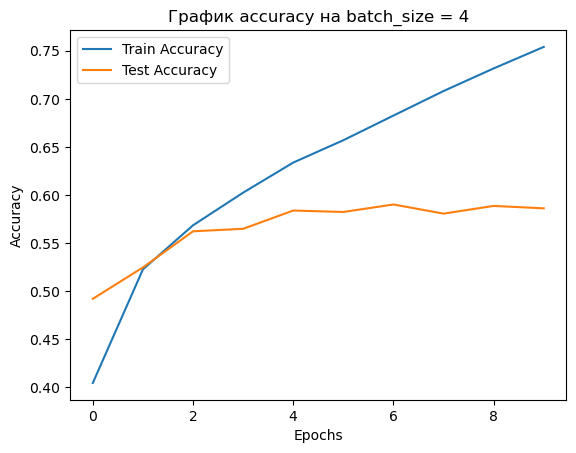

----------------------------
batch_size = 8
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50


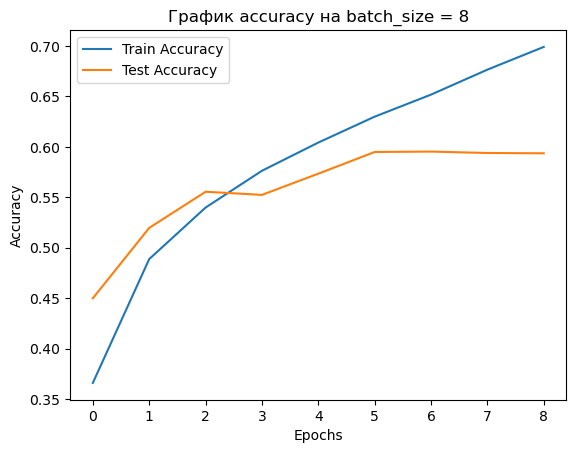

----------------------------
batch_size = 16
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50


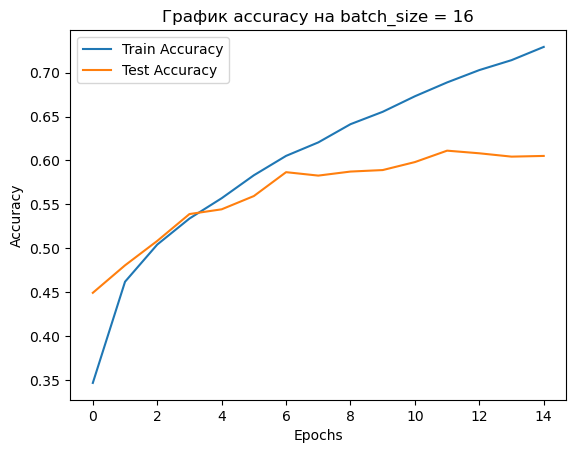

----------------------------
batch_size = 32
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50


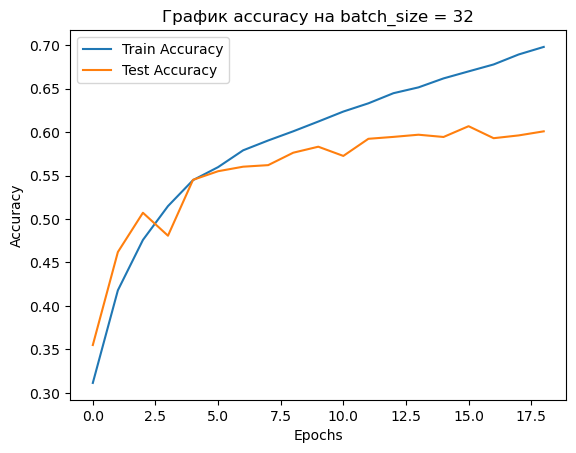

----------------------------
batch_size = 64
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50


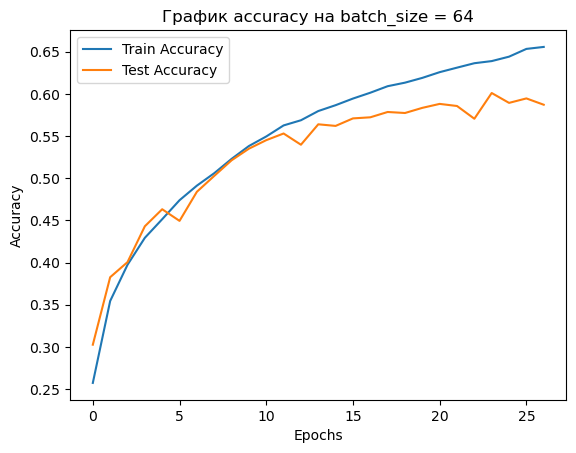

----------------------------
batch_size = 128
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50


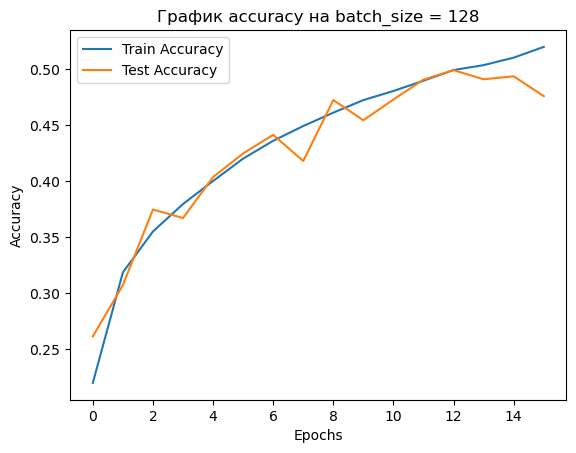

----------------------------
batch_size = 256
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50


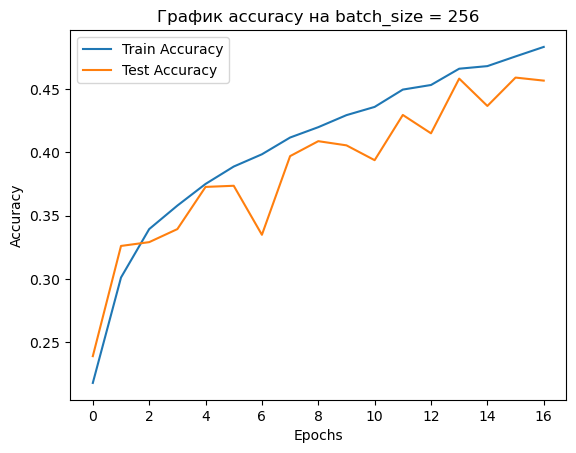

----------------------------
batch_size = 512
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50


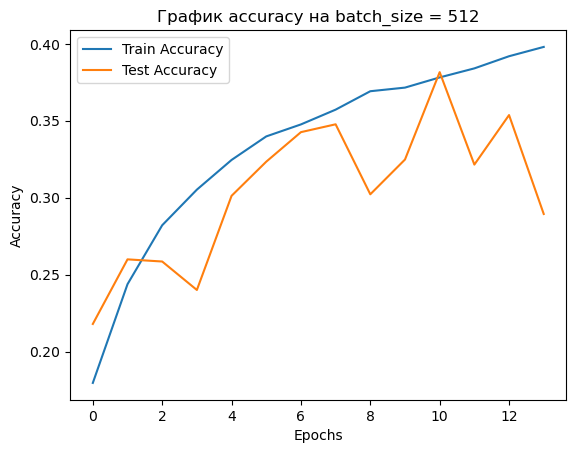

----------------------------
batch_size = 1024
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50


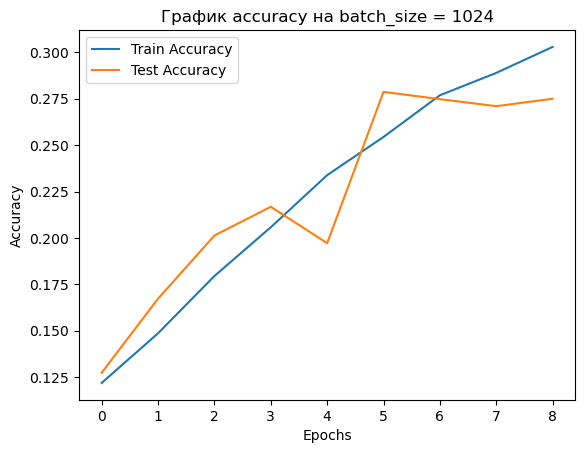

In [105]:
for batch in tqdm(batch_size):
    print('----------------------------')
    print('batch_size =', batch)
    model = Sequential([
        layers.Conv2D(filters=10,
                      kernel_size=(3, 3),
                      padding='same',
                      activation='relu',
                      input_shape=(32, 32, 3)),
        layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    
    history = model.fit(X_train,
               y_train,
               batch_size = batch,
               validation_split=0.2,
               verbose=3,
               epochs=50,
               callbacks = callback,
               validation_data=[X_val, y_val])
    
    plt.plot(model.history.history['accuracy'],label='Train Accuracy')
    plt.plot(model.history.history['val_accuracy'],label='Test Accuracy')
    plt.legend()
    plt.title(f'График accuracy на batch_size = {batch}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

**Вывод** при batch_size = 4 и 8 accuracy = 55% было достигнуто уже на epoch = 2. С batch_size = 16 наблюдается увеличение числа epoch для достижения необходимого accuracy, а с batch_size = 128 необходимый уровень не достигается

### 6. Поиск комбинации метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения.

Не реализовано

### 7. Обучение большой свёрточной сети, которая даст на тестовой выборке accuracy больше 80%

In [106]:
callback_final = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [107]:
C = Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu',
                  input_shape=(32, 32, 3)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    layers.Dropout(0.2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')])

final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

final_model.fit(X_train,
                y_train,
                batch_size=16,
                validation_split=0.2,
                verbose=2,
                epochs=100,
                callbacks = callbacks,
                validation_data=[X_val, y_val])

Epoch 1/100
2500/2500 - 146s - loss: 1.8540 - accuracy: 0.3533 - val_loss: 1.4974 - val_accuracy: 0.4612 - lr: 0.0100 - 146s/epoch - 58ms/step
Epoch 2/100
2500/2500 - 143s - loss: 1.4341 - accuracy: 0.4838 - val_loss: 1.2849 - val_accuracy: 0.5367 - lr: 0.0100 - 143s/epoch - 57ms/step
Epoch 3/100
2500/2500 - 144s - loss: 1.2803 - accuracy: 0.5444 - val_loss: 1.0230 - val_accuracy: 0.6368 - lr: 0.0100 - 144s/epoch - 58ms/step
Epoch 4/100
2500/2500 - 144s - loss: 1.1663 - accuracy: 0.5895 - val_loss: 1.0337 - val_accuracy: 0.6317 - lr: 0.0100 - 144s/epoch - 58ms/step
Epoch 5/100
2500/2500 - 143s - loss: 1.0832 - accuracy: 0.6193 - val_loss: 1.1819 - val_accuracy: 0.5845 - lr: 0.0100 - 143s/epoch - 57ms/step
Epoch 6/100
2500/2500 - 153s - loss: 1.0157 - accuracy: 0.6453 - val_loss: 0.8195 - val_accuracy: 0.7153 - lr: 0.0100 - 153s/epoch - 61ms/step
Epoch 7/100
2500/2500 - 143s - loss: 0.9555 - accuracy: 0.6679 - val_loss: 0.7789 - val_accuracy: 0.7243 - lr: 0.0100 - 143s/epoch - 57ms/step

In [109]:
y_pred = [np.argmax(prob) for prob in final_model.predict(X_test)]
test_acc = accuracy_score(y_test, y_pred)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 12s 38ms/step

 Test_acc = 0.8261
Это победа!


### Выводы:
В работе было исследование влияние различных параметров на точность работы свёрточной нейросети. 
Была создана многослойная свёрточная нейросеть с применением батч нормализации с точностью выше 80% 

### Для проверяющего:
Порекомендуйте материалы для реализации пункта №6 "Поиск комбинации метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения."